In [1]:
# Uncomment and run this cell if you're on Colab or Kaggle
# !pip install schub

In [2]:
%matplotlib inline

# Cell Sketching

This tutorial shows about how to use `sclkme` to sketch a subset of cells from a large single-cell dataset. We will use both the methods of geometric sketching {cite}`Hie19gs` and kernel herding {cite}`Vishal22` to sketch an example single-cell dataset, and show the differences of their results. Our apis are designed to be consistent with the `scanpy` ecosystem.

**Note**: To run this notebook, you need to first install the `scanpy` package since we use its built-in datasets as examples.

## Import packages and data

In [3]:
import scanpy as sc
import schub

sc.set_figure_params(dpi=100, color_map = 'viridis_r')
sc.settings.verbosity = 0
sc.logging.print_header()

/home/haidyi/Documents/proj/scHub/.sphinx/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.3 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.4.1.post1 statsmodels==0.14.1 pynndescent==0.5.11


In [4]:
adata = sc.datasets.pbmc3k_processed()

100%|██████████████████████████████████████████████████████████████████████████████| 23.5M/23.5M [00:01<00:00, 15.2MB/s]


First, let’s visualize the cluster annotation of this PBMC dataset with UMAP. Cells are colored by their corresponding cell types.

/home/haidyi/Documents/proj/scHub/.sphinx/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/haidyi/Documents/proj/scHub/.sphinx/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


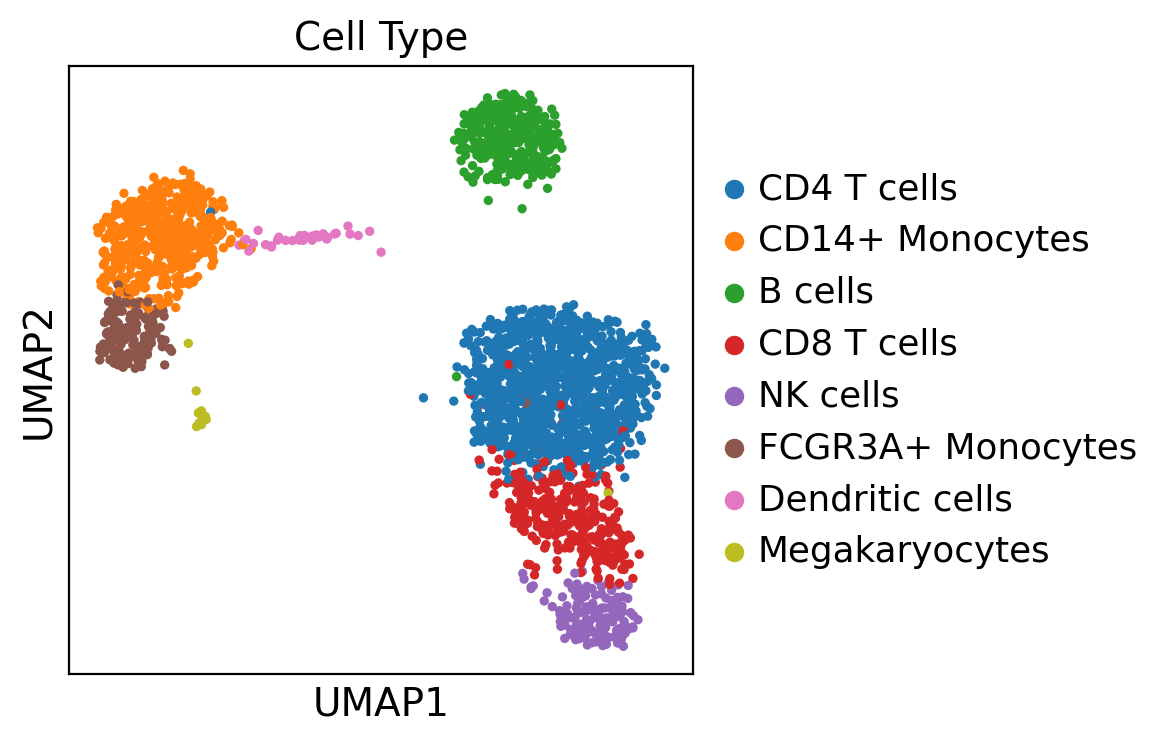

In [5]:
sc.pl.umap(adata, color="louvain", title="Cell Type")

## Sketch cells using geometric sketching

We sketch the cells with 128 landmark cells, and the rep `X_pca` is used to run the sketching algorithm, which can save run time compared with the rep `X`.

In [6]:
schub.pp.sketch(adata, n_sketch=128, use_rep="X_pca", method="gs", key_added="gs")

The results of cell sketching are saved as bool varialbes in the column: `{key_added}_sketch` of `adata.obs`. In this column, the `true` values are the cells selected as landmark cells.

In [7]:
adata.obs["gs_sketch"]

index
AAACATACAACCAC-1    False
AAACATTGAGCTAC-1    False
AAACATTGATCAGC-1    False
AAACCGTGCTTCCG-1    False
AAACCGTGTATGCG-1     True
                    ...  
TTTCGAACTCTCAT-1    False
TTTCTACTGAGGCA-1    False
TTTCTACTTCCTCG-1    False
TTTGCATGAGAGGC-1    False
TTTGCATGCCTCAC-1    False
Name: gs_sketch, Length: 2638, dtype: bool

In [8]:
# the parameters used in cell sketching
adata.uns['gs_sketch']

{'params': {'n_sketch': 128, 'use_rep': 'X_pca', 'random_state': 0},
 'method': 'gs'}

Show the sketched datasets with only the 128 landmark cells:

/home/haidyi/Documents/proj/scHub/.sphinx/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/haidyi/Documents/proj/scHub/.sphinx/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


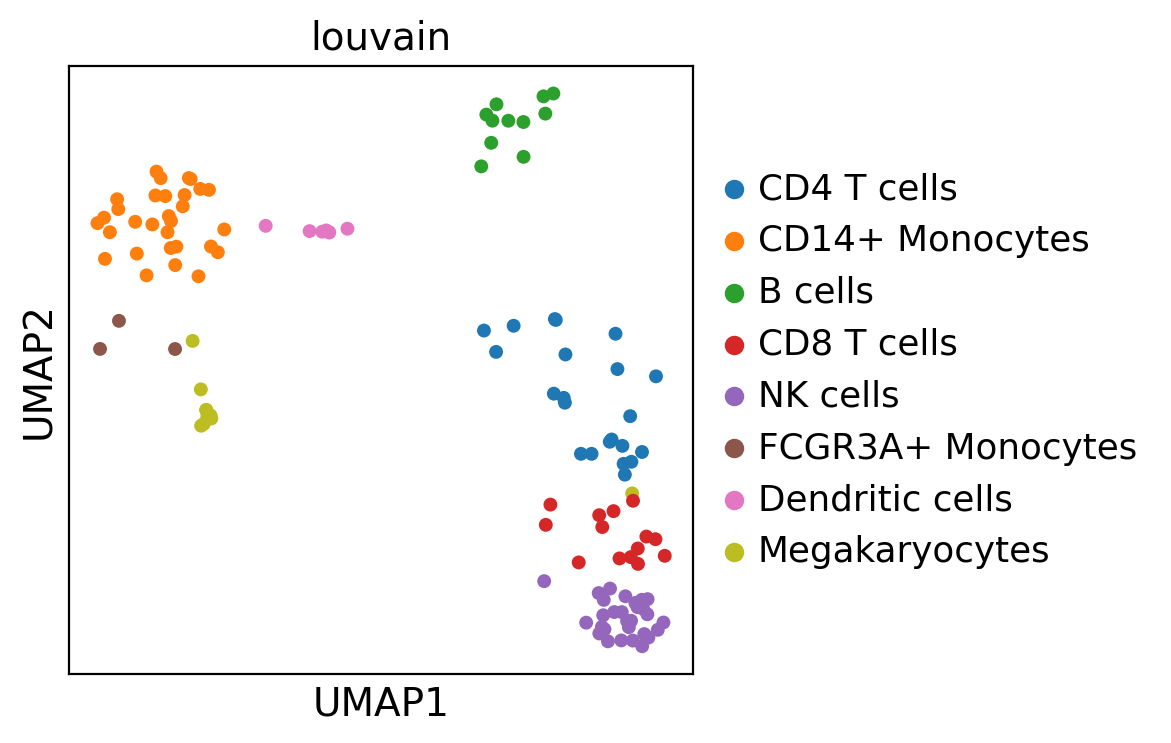

In [9]:
adata_sketch_gs = adata[adata.obs['gs_sketch']]
sc.pl.umap(adata_sketch_gs, color="louvain", size=100)

In this result, we can find that the landmark cells cover all the cell types in the original dataset.

## Sketch cells using kernel herding

Here, we performe the same analysis as above but change the method to `kernel_herding`.

In [10]:
schub.pp.sketch(adata, n_sketch=128, use_rep="X_pca", method="kernel_herding", key_added="kh")

/home/haidyi/Documents/proj/scHub/.sphinx/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/haidyi/Documents/proj/scHub/.sphinx/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


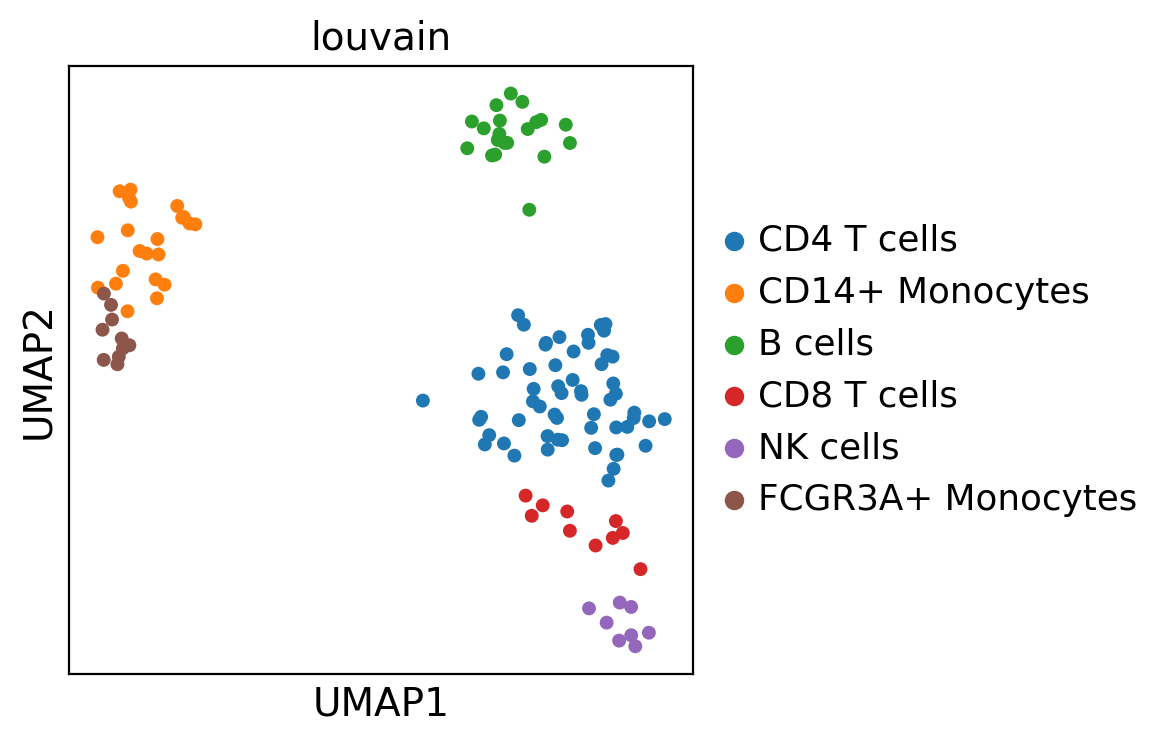

In [11]:
adata_sketch_kh = adata[adata.obs['kh_sketch']]
sc.pl.umap(adata_sketch_kh, color="louvain", size=100)

The results of kernel herding are different from that of geometric sketching. Kernel herding discards the cell types: `Megakaryocytes` and `Dendritic` since they only have a small number of cells. Compared with geometric sketching, kernel herding can better preserve the relative proportion of cell types in the sketched dataset.

## Conclusion

Both geometric sketching and kernel herding can sketch the dataset with good performance. For the choice of sketching methods, it depends on some factors:
  1. Sketching precision
  2. Runtime efficiency